# fastMRI
Python 3.6+, Tensorflow 2.0.0-dev20190601

In [1]:
ll -h /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5

-rw-rw-r-- 1 ubuntu 91M May 31 18:39 /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [5]:
import cs230_project_utilities as utils

# Loading the data

In [6]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
dataset_directory = '/home/ubuntu/cs230/data/fastmri/raw'

In [7]:
def find_dataset_files(dataset_directory):
    # Find .h5 and .txt files in `dataset_directory`
    # Assuming at most one name.h5 and one name.txt file in `dataset_directory`.
    h5_file_pattern = os.path.join(dataset_directory, '*.h5')
    text_file_pattern = os.path.join(dataset_directory, '*.txt')
    h5_paths = glob.glob(h5_file_pattern)
    text_paths = glob.glob(text_file_pattern)
    print('Found {} .h5 files and {} .txt files.'.format(len(h5_paths), len(text_paths)))
    
    # Merge .h5 and .txt paths into one data structure: a dict where key is filename
    # without extension and value is dict {'h5': h5_path, 'text': text_path}.
    get_filename = lambda path: os.path.splitext(os.path.basename(path))[0]
    files = {}
    for path in h5_paths:
        filename = get_filename(path)
        files[filename] = {'h5': path}
    for path in text_paths:
        filename = get_filename(path)
        files[filename]['text'] = path
      
    return files

In [8]:
# Find all the files in our dataset
files = find_dataset_files(dataset_directory)

Found 6 .h5 files and 0 .txt files.


In [9]:
files['file1000000']['h5']

'/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5'

In [10]:
# Load example files
example = files['file1000000']
print(example)

{'h5': '/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5'}


In [11]:
h5 = example['h5']

In [12]:
# Handle .h5 files

def inspect_h5_file(path):
    with h5py.File(path, 'r') as f:
        # Looks like .h5 files are like dictionaries
        print('Found keys: {}'.format(f.keys()))
        
        # Let's find all the nested keys
        print('\nFinding nested keys...')
        show_keys_for_h5_file(path)
        
        # Unwrap the data stored in the keys
        # known keys: 'clasificacion', 'images', 'kspace/mag', 'kspace/phase'
        print('\nUnwrapping data at known keys...')
        ismrmrd_header = f['ismrmrd_header']
        kspace = f['kspace']
        reconstruction_esc = f['reconstruction_esc']
        reconstruction_rss = f['reconstruction_rss']
        print(ismrmrd_header)
        print(kspace)
        print(reconstruction_esc)
        print(reconstruction_rss)

def show_keys_for_h5_file(path):
    '''
    Convenience function for printing the nested keys in an
    .h5 file.
    '''
    def print_nested_keys(key, value):
        print(key)
        for k, v in value.attrs.items():
            print('{}: {}'.format(key, val))

    with h5py.File(path, 'r') as f:
        f.visititems(print_nested_keys)
        
def read_h5_file(path):
    '''
    Reads a .h5 file from `path`, unwrapping data stored in the known
    keys: 'clasificacion', 'images', 'kspace/mag', 'kspace/phase'.
    '''
    with h5py.File(path, 'r') as f:
        metadata = f['ismrmrd_header'].value
        kspace = f['kspace'].value
        reconstruction_esc = f['reconstruction_esc'].value
        reconstruction_rss = f['reconstruction_rss'].value
        
#     # Convert to float32 and scale data to [0, 1]
#     images = images.astype(np.float32)
#     images -= images.min(axis=(1, 2), keepdims=True)
#     images /= images.max(axis=(1, 2), keepdims=True)
    print(kspace.shape)
    
#     # Additional conversion scaling here with magnitude data.
#     # Most ML and scientific frameworks expect data to be in [0, 1].
#     magnitude = magnitude.astype(np.float32)
#     magnitude -= magnitude.min(axis=(1, 2), keepdims=True)
#     magnitude /= magnitude.max(axis=(1, 2), keepdims=True)
    
#     phase = phase.astype(np.float32)
    # Don't scale phase (it represents an angle, so it's always in [0, pi])
    
    return {'metadata': metadata,
            'kspace': kspace,
            'reconstruction_esc': reconstruction_esc,
            'reconstruction_rss': reconstruction_rss}
    
# Handle .txt files

def inspect_text_file(path):
    with open(path, 'rb') as f:
        print(f.read())


In [13]:
# Let's look at a single .h5 file
inspect_h5_file(h5)

Found keys: KeysView(<HDF5 file "file1000000.h5" (mode r)>)

Finding nested keys...
ismrmrd_header
kspace
reconstruction_esc
reconstruction_rss

Unwrapping data at known keys...
<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (35, 640, 368), type "<c8">
<HDF5 dataset "reconstruction_esc": shape (35, 320, 320), type "<f4">
<HDF5 dataset "reconstruction_rss": shape (35, 320, 320), type "<f4">


# Visualizing the data

In [14]:
# Finally, we can see the raw data
h5_data = read_h5_file(h5)
print(h5_data.keys())

metadata = h5_data['metadata']
kspace = h5_data['kspace']
reconstruction_esc = h5_data['reconstruction_esc']
reconstruction_rss = h5_data['reconstruction_rss']

# (Note: shape of magnitude and phase are different from image)
print(kspace.shape, reconstruction_esc.shape, reconstruction_rss.shape)

(35, 640, 368)
dict_keys(['metadata', 'kspace', 'reconstruction_esc', 'reconstruction_rss'])
(35, 640, 368) (35, 320, 320) (35, 320, 320)


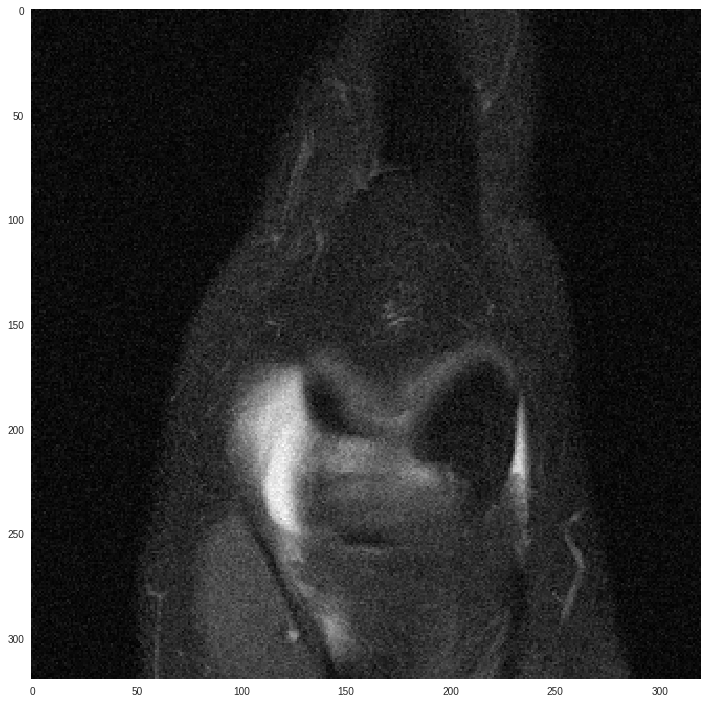

In [15]:
utils.plot.imshowgray(reconstruction_esc[10])

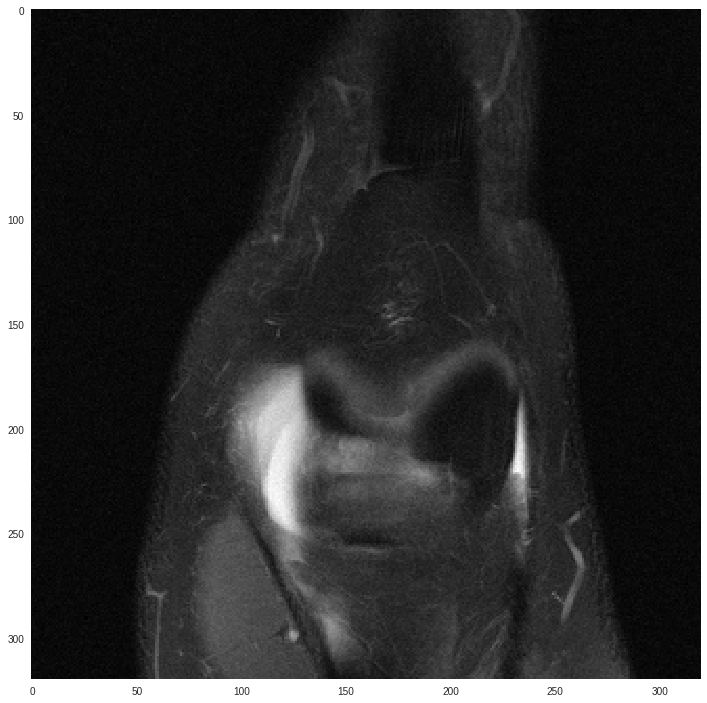

In [16]:
utils.plot.imshowgray(reconstruction_rss[10])

In [17]:
def center_crop(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.
    Args:
        data (np.ndarray): The complex input tensor to be center cropped. It should
            have at least 2 dimensions and the cropping is applied along dimensions
            0 and 1.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.
    Returns:
        np.ndarray: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[0]
    assert 0 < shape[1] <= data.shape[1]
    w_from = (data.shape[0] - shape[0]) // 2
    h_from = (data.shape[1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[w_from:w_to, h_from:h_to, ...]

In [18]:
# def ifft2d(x):
#     x = np.fft.ifftshift(x, (0, 1))
#     x = np.fft.ifft2(x, norm='ortho')
#     x = np.fft.fftshift(x, (0, 1))
#     return x

# def fft2d(x):
#     x = np.fft.ifftshift(x, (0, 1))
#     x = np.fft.fft2(x, norm='ortho')
#     x = np.fft.fftshift(x, (0, 1))
#     return x

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


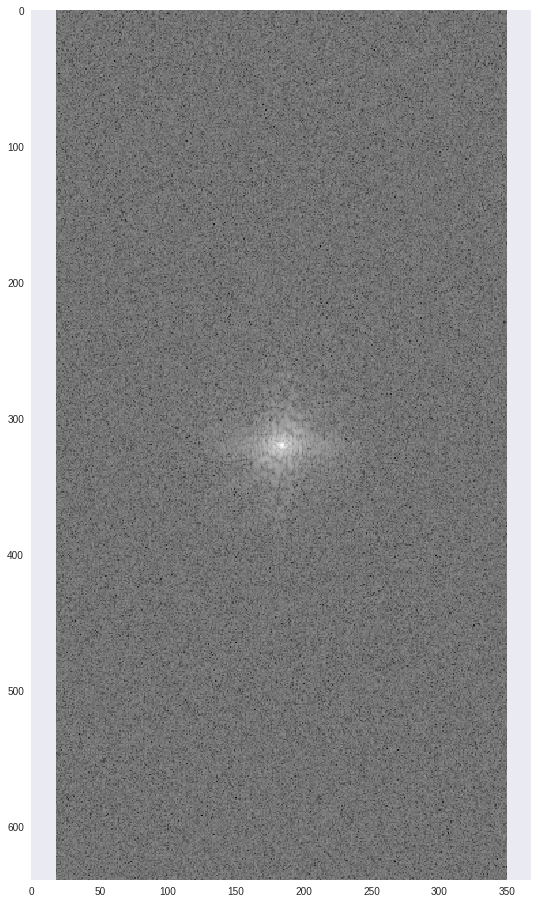

In [19]:
utils.plot.imshowfft(kspace[10])

In [20]:
out_numpy = utils.signal_processing.ifft2d(kspace[10])
print(out_numpy.shape)
out_numpy = center_crop(out_numpy, (320, 320))
print(out_numpy.shape)

(640, 368)
(320, 320)


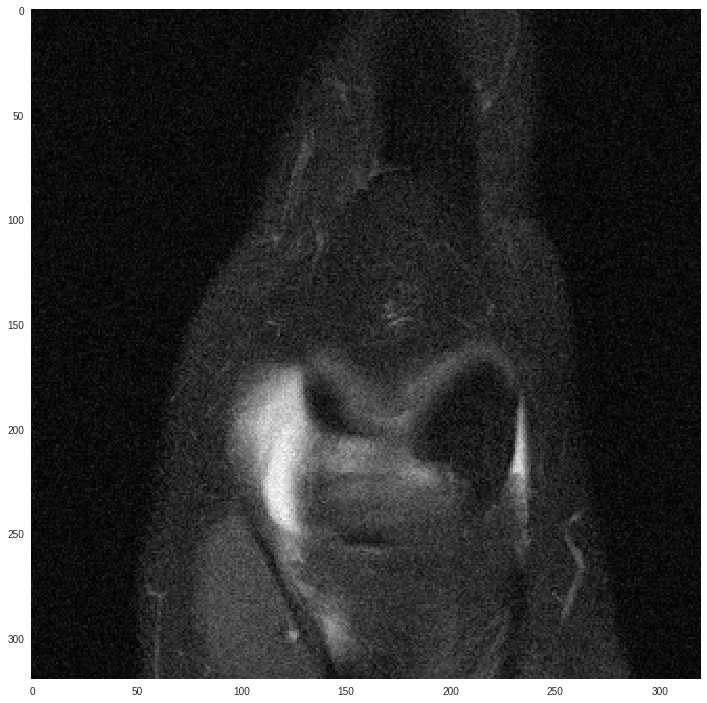

In [21]:
utils.plot.imshowgray(np.abs(out_numpy))

In [22]:
np.allclose(reconstruction_esc[10], np.abs(out_numpy))

True

In [23]:
np.allclose(reconstruction_rss[10], np.abs(out_numpy), atol=1e-4)

True

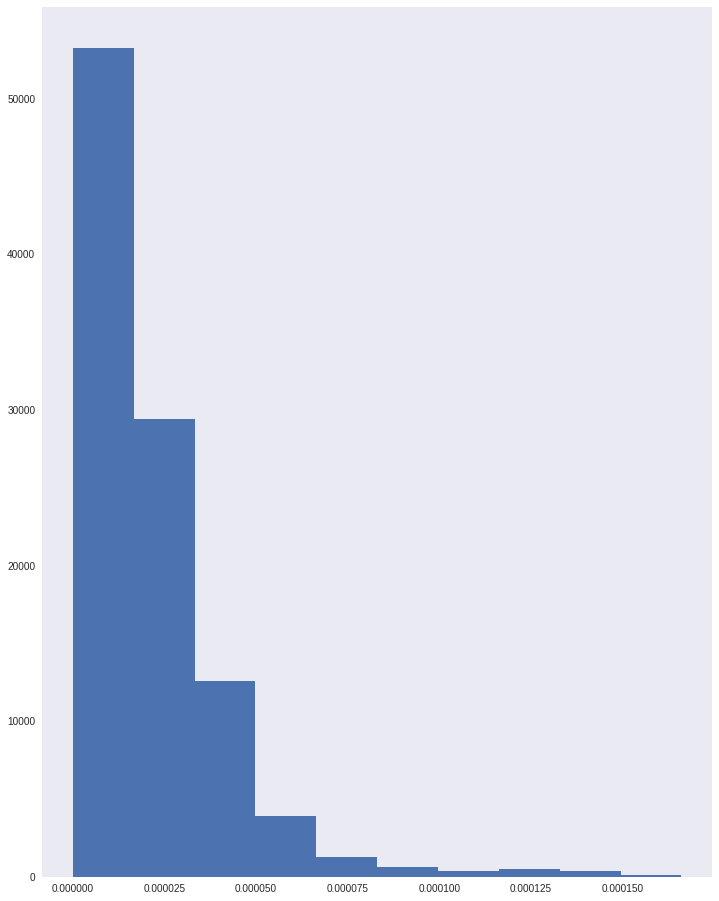

In [24]:
plt.hist(np.abs(out_numpy).flatten());

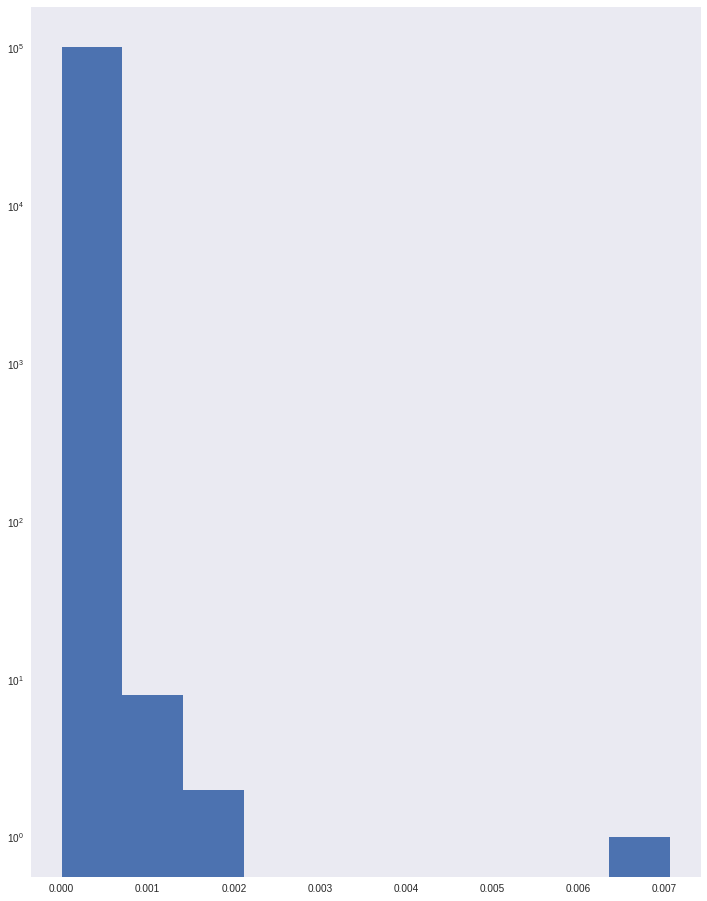

In [25]:
out_numpy = utils.signal_processing.fft2d(reconstruction_rss[10])
plt.hist(np.abs(out_numpy).flatten(), log=True);

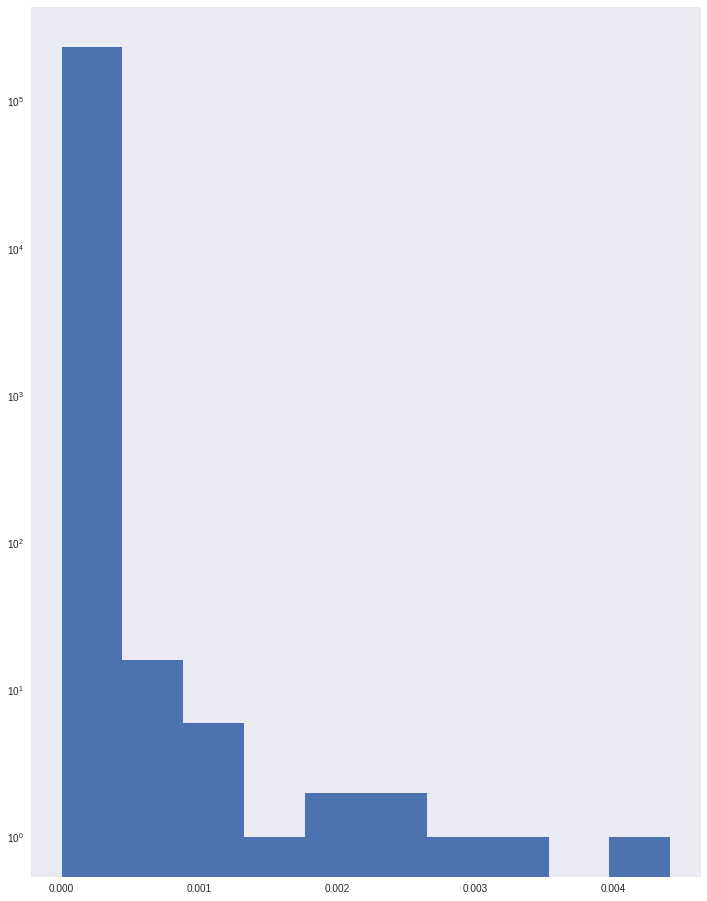

In [26]:
plt.hist(np.abs(kspace[10]).flatten(), log=True);

In [27]:
kspace[10].shape, out_numpy.shape

((640, 368), (320, 320))

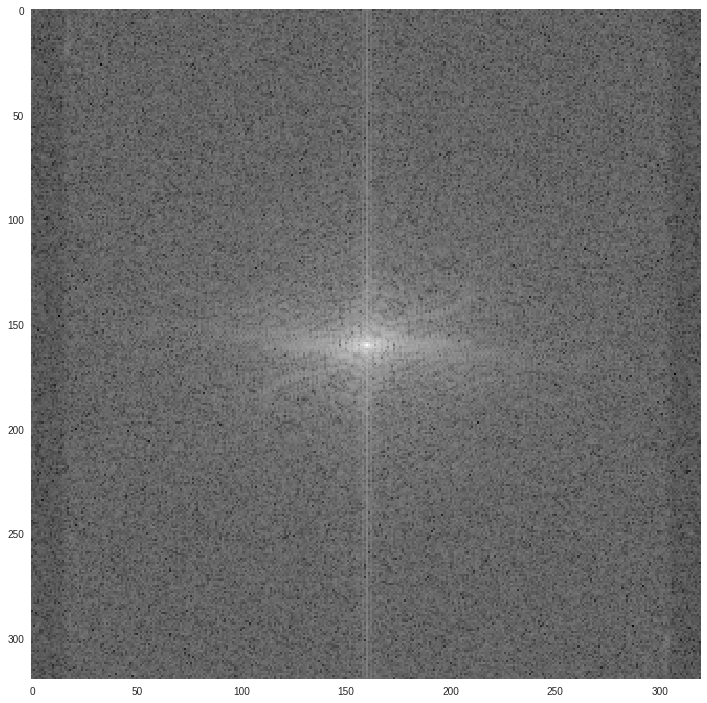

In [28]:
utils.plot.imshowfft(out_numpy)

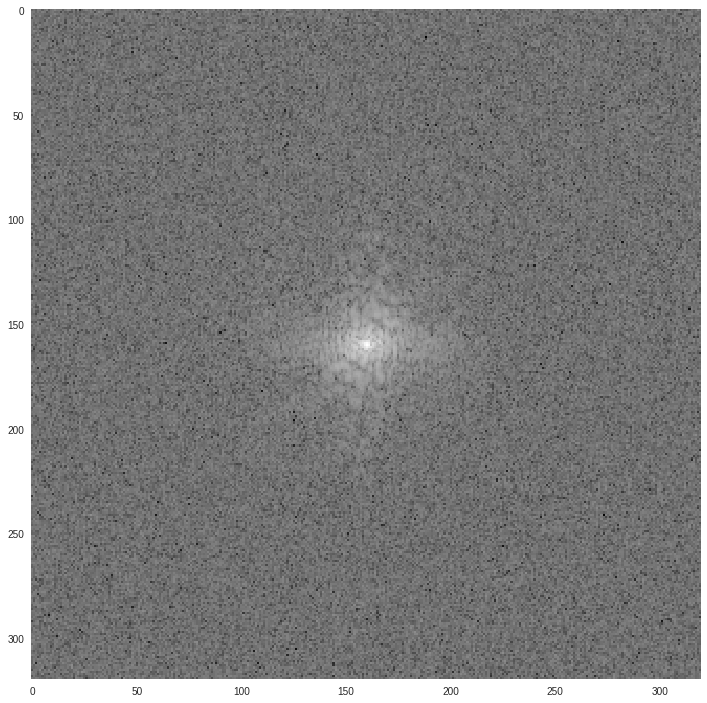

In [29]:
utils.plot.imshowfft(center_crop(kspace[10], (320, 320)))

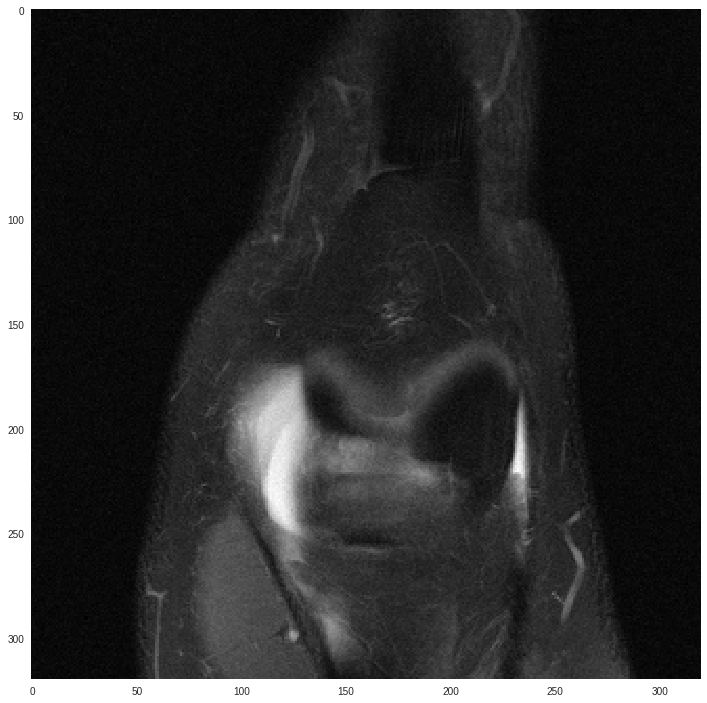

In [30]:
utils.plot.imshowgray(np.abs(utils.signal_processing.ifft2d(out_numpy)))

In [31]:
np.allclose(np.abs(utils.signal_processing.ifft2d(out_numpy)), reconstruction_esc[10], atol=1e-4)

True

In [32]:
np.allclose(np.abs(utils.signal_processing.ifft2d(out_numpy)), reconstruction_rss[10], atol=1e-4)

True

In [33]:
def apply_mask(data, mask_func, seed=None):
    """
    Subsample given k-space by multiplying with a mask.
    Args:
        data (torch.Tensor): The input k-space data. This should have at least 3 dimensions, where
            dimensions -3 and -2 are the spatial dimensions, and the final dimension has size
            2 (for complex values).
        mask_func (callable): A function that takes a shape (tuple of ints) and a random
            number seed and returns a mask.
        seed (int or 1-d array_like, optional): Seed for the random number generator.
    Returns:
        (tuple): tuple containing:
            masked data (torch.Tensor): Subsampled k-space data
            mask (torch.Tensor): The generated mask
    """
    shape = np.array(data.shape)
    shape[:-3] = 1
    mask = mask_func(shape, seed)
    return data * mask, mask

In [34]:
class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.
    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)
    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.
    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.
            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))

        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        
        print('num_cols:', num_cols)
        print('num_low_freqs:', num_low_freqs)
        print('prob:', prob)
        
        print(mask.sum())
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        
        mask = np.reshape(mask, mask_shape).astype(np.float32)
#         mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask

In [35]:
kspace_fully_sampled = np.expand_dims(kspace[10], -1)

In [36]:
fully_sampled_recon = np.abs(utils.signal_processing.ifft2d(kspace_fully_sampled.squeeze()))

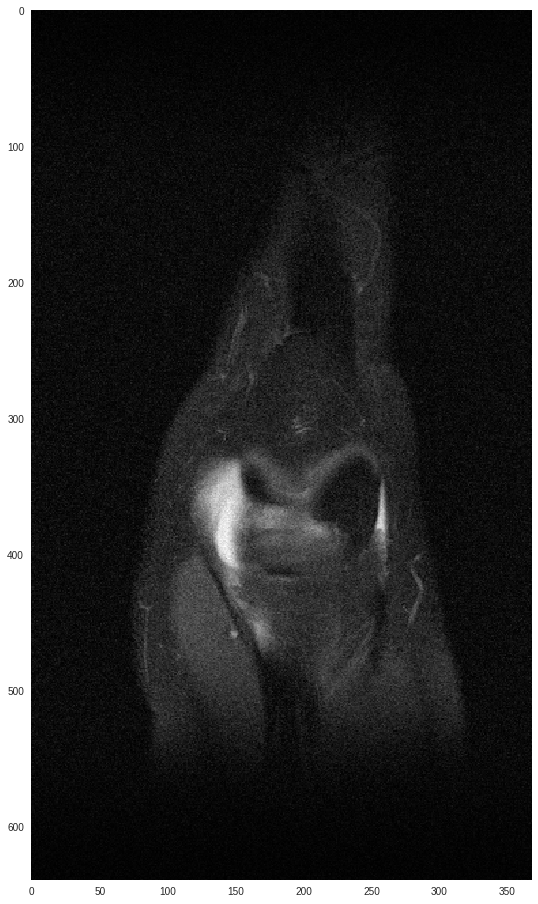

In [37]:
utils.plot.imshowgray(fully_sampled_recon.squeeze())

In [38]:
subsampling_mask_function = MaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])

In [39]:
subsampling_mask = subsampling_mask_function(shape=kspace_fully_sampled.shape)

num_cols: 368
num_low_freqs: 15
prob: 0.08781869688385269
30


In [40]:
kspace_subsampled = subsampling_mask * kspace_fully_sampled

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


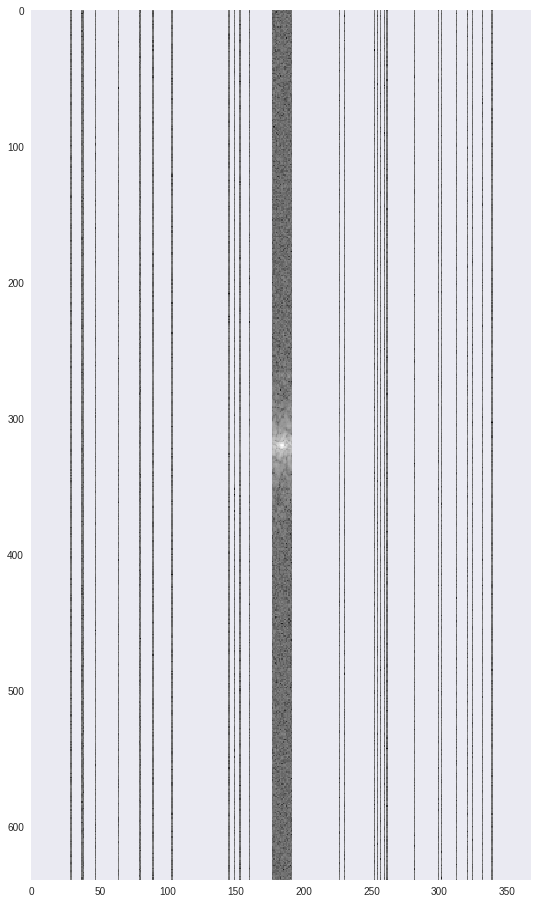

In [41]:
utils.plot.imshowfft(kspace_subsampled.squeeze())

In [42]:
kspace_fully_sampled.shape

(640, 368, 1)

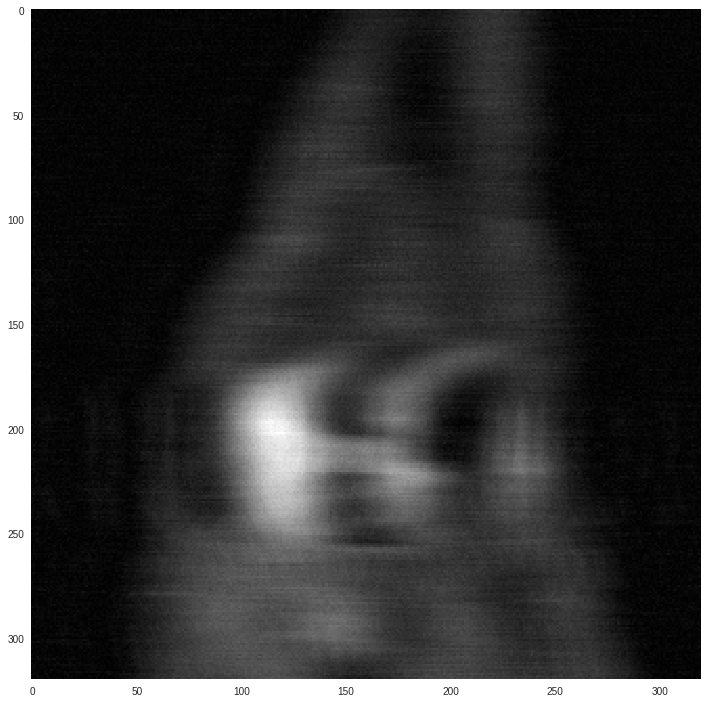

In [43]:
cropped_subsampled_recon = center_crop(np.abs(utils.signal_processing.ifft2d(kspace_subsampled.squeeze())), (320, 320))
utils.plot.imshowgray(cropped_subsampled_recon)

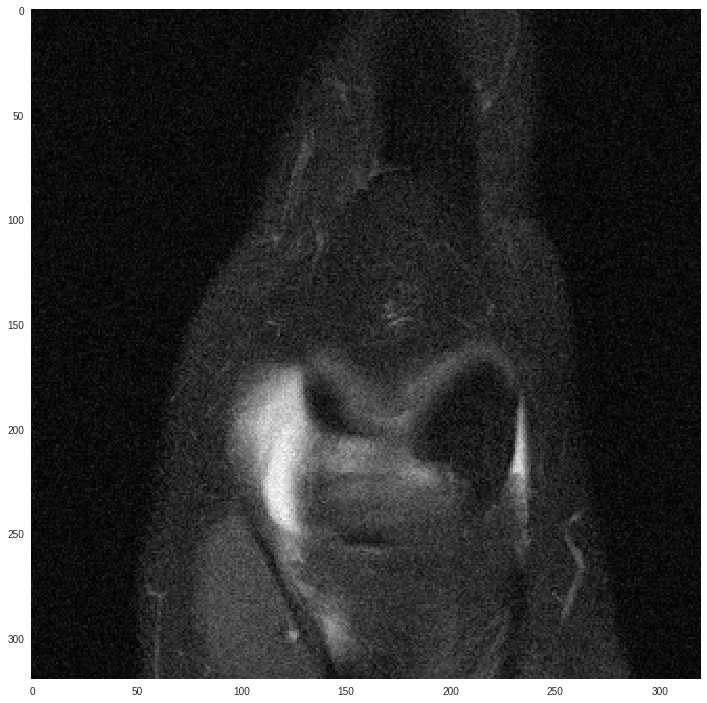

In [44]:
cropped_fully_sampled_recon = center_crop(np.abs(utils.signal_processing.ifft2d(kspace_fully_sampled.squeeze())), (320, 320))
utils.plot.imshowgray(cropped_fully_sampled_recon)

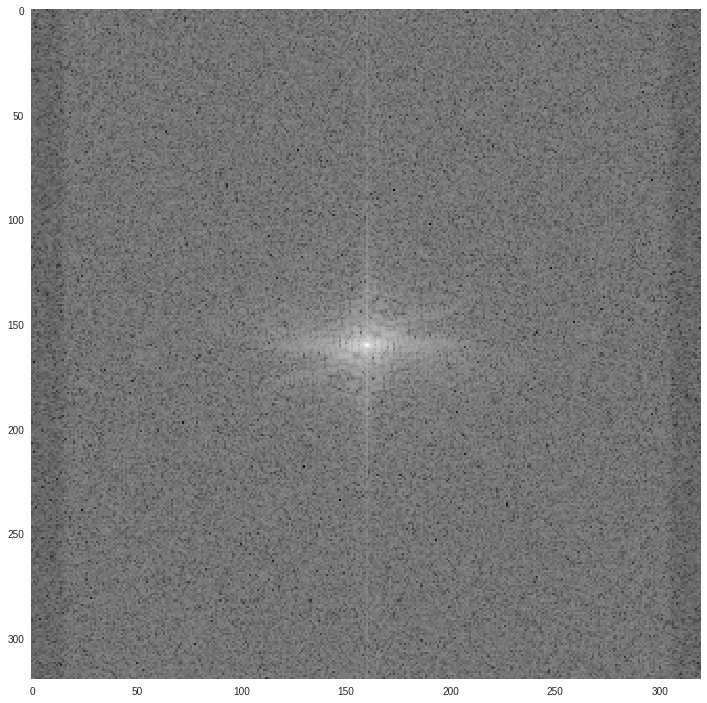

In [45]:
new_kspace = utils.signal_processing.fft2d(cropped_fully_sampled_recon)
utils.plot.imshowfft(new_kspace)

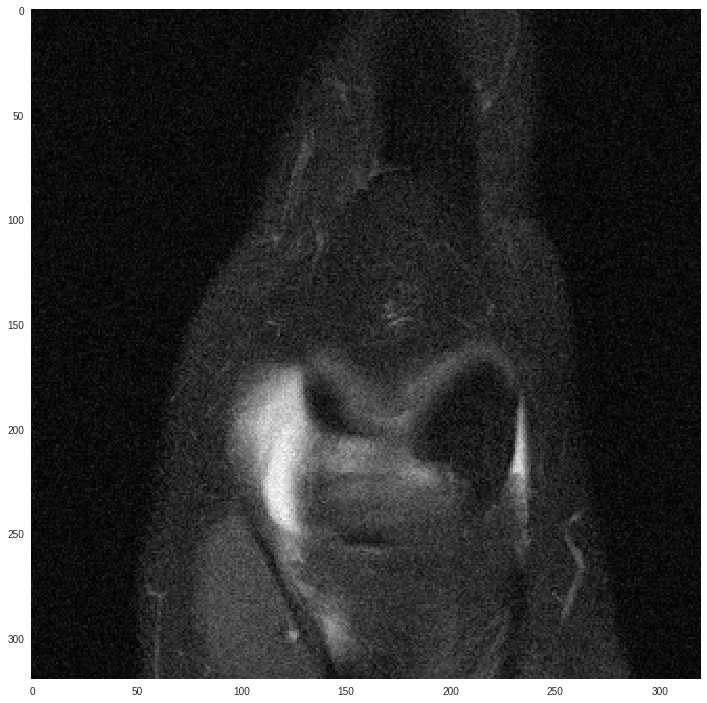

In [46]:
new_recon = np.abs(utils.signal_processing.ifft2d(new_kspace))
utils.plot.imshowgray(new_recon)

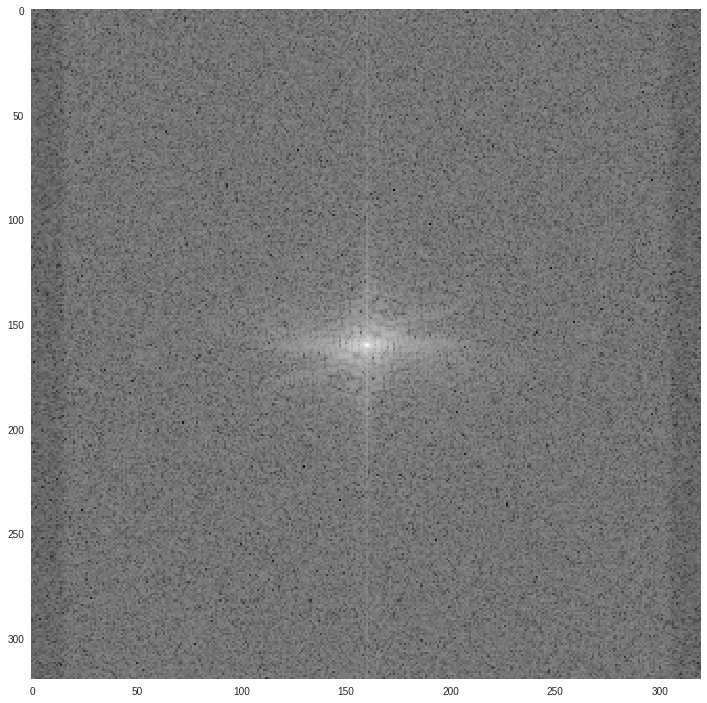

True

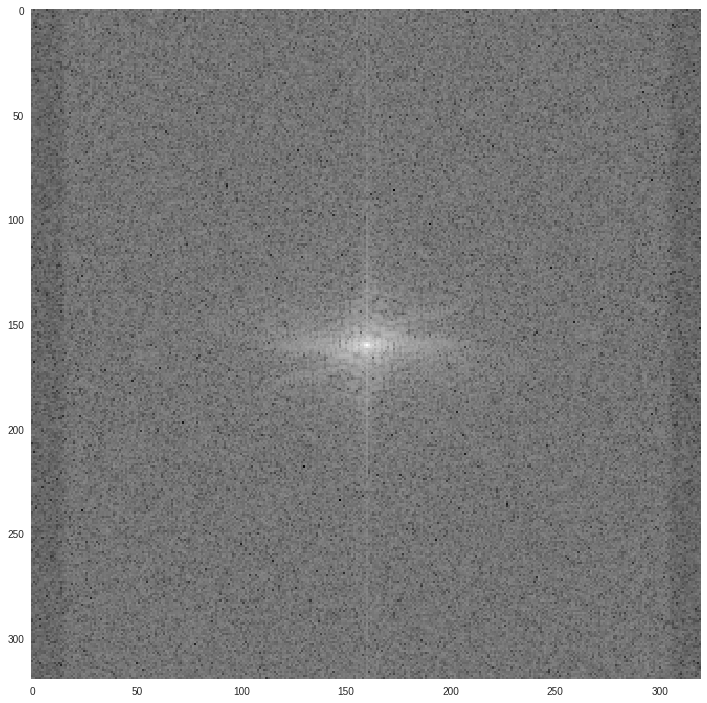

In [47]:
# Great, shows recon from full kspace then crop same as crop of target recon then fft.
kspace_from_original_kspace = utils.signal_processing.fft2d(center_crop(np.abs(utils.signal_processing.ifft2d(kspace[10])), new_kspace.shape[:2]))
kspace_from_recon = utils.signal_processing.fft2d(center_crop(reconstruction_esc[10], new_kspace.shape[:2]))
utils.plot.imshowfft(kspace_from_original_kspace)
plt.show()
utils.plot.imshowfft(kspace_from_recon)
np.allclose(kspace_from_original_kspace, kspace_from_recon)

In [48]:
utils.signal_processing.mean_square_error(kspace_from_original_kspace, kspace_from_recon)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/signal_processing.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.mean(np.square(A.astype(float) - B.astype(float)))


3.9178483162925423e-25

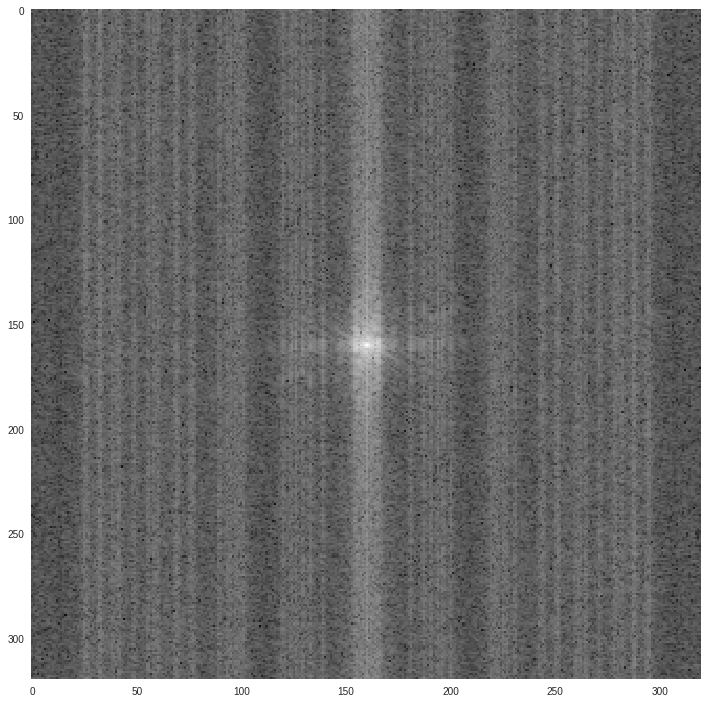

In [49]:
new_kspace_subsampled = utils.signal_processing.fft2d(cropped_subsampled_recon)
utils.plot.imshowfft(new_kspace_subsampled)

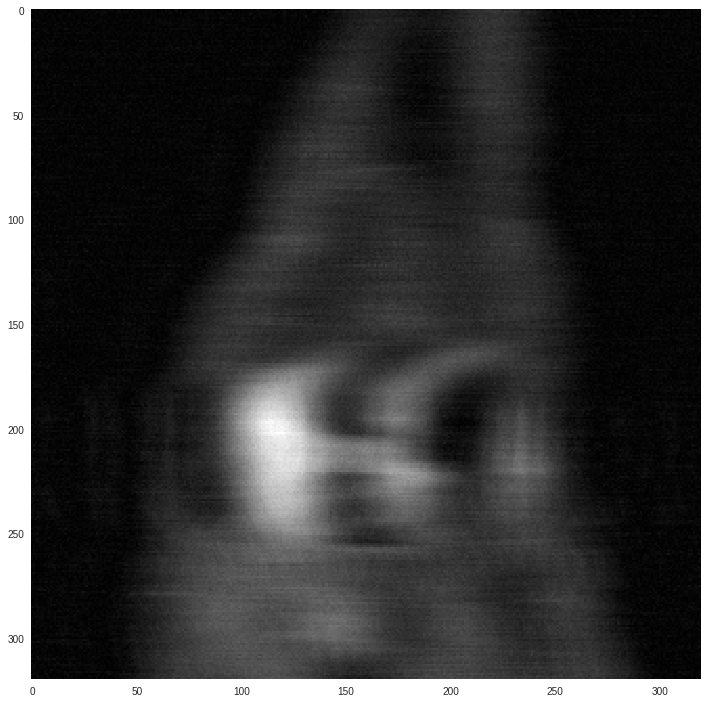

In [50]:
new_recon_subsampled = np.abs(utils.signal_processing.ifft2d(new_kspace_subsampled))
utils.plot.imshowgray(new_recon_subsampled)

In [51]:
np.allclose(new_recon_subsampled, cropped_subsampled_recon)

True

In [52]:
import tensorflow as tf

In [53]:
def tile_four_reflections(image):
    top_left = image 
    top_right = tf.image.flip_up_down(image)
    bottom_left = tf.image.flip_left_right(image)
    bottom_right = tf.image.flip_left_right(top_right)
    
    top = tf.concat([top_left, top_right], axis=1)
    bottom = tf.concat([bottom_left, bottom_right], axis=1)
    
    tiled = tf.concat([top, bottom], axis=0)
    
    return tiled

In [54]:
kspace_from_recon

array([[ 3.14207031e-06+9.47011625e-23j,  2.80786670e-07-3.59397292e-07j,
        -3.69335891e-06+1.94745946e-06j, ...,
         1.52933005e-06+7.47293021e-07j, -3.69335891e-06-1.94745946e-06j,
         2.80786670e-07+3.59397292e-07j],
       [-5.38506658e-06-4.07352343e-07j,  2.83759353e-06+1.47198593e-07j,
        -4.61500107e-06-2.55820364e-06j, ...,
        -6.51063040e-07-9.19958209e-07j,  3.20544261e-07-8.21664655e-07j,
         4.33264703e-06+2.55789462e-07j],
       [-3.85920820e-07+1.44052277e-06j,  1.32516293e-06-2.30290093e-06j,
         1.52179763e-06+2.32216189e-06j, ...,
         1.36291574e-06+1.86031297e-06j, -2.19119785e-06+8.35604717e-07j,
         1.83302985e-06+9.13757723e-07j],
       ...,
       [-1.04990925e-06+2.50886817e-06j,  1.31344560e-06-1.33498704e-06j,
        -1.62666399e-06+3.22951230e-06j, ...,
        -5.62333457e-07-1.10123853e-06j, -3.79377728e-07-5.30514068e-07j,
        -1.27753850e-06-3.30517030e-06j],
       [-3.85920820e-07-1.44052277e-06j,  1.

In [55]:
tiled_recon = tile_four_reflections(np.expand_dims(cropped_fully_sampled_recon, -1))

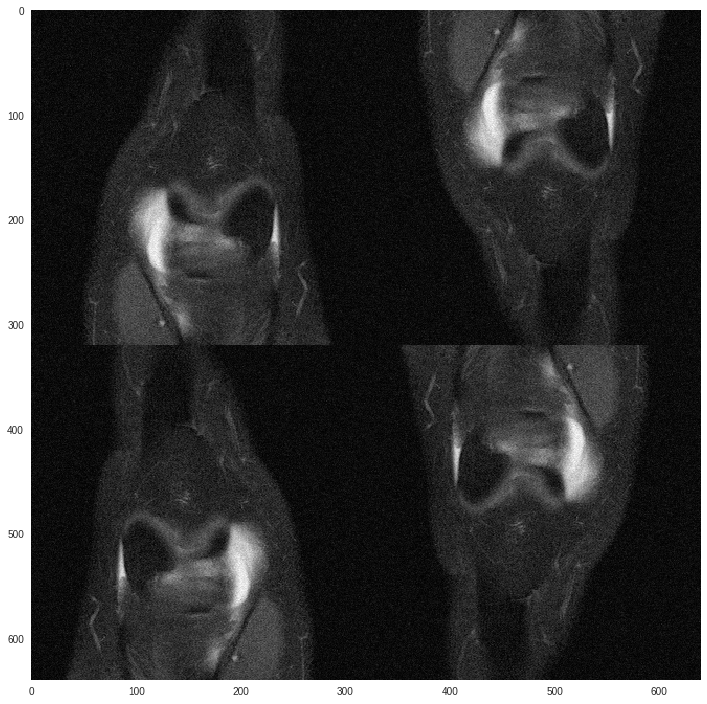

In [56]:
utils.plot.imshowgray(tiled_recon.numpy().squeeze())

In [57]:
cropped_tiled_recon = tf.image.random_crop(tiled_recon, size=(tiled_recon.shape[0] // 2, tiled_recon.shape[1] // 2, 1))

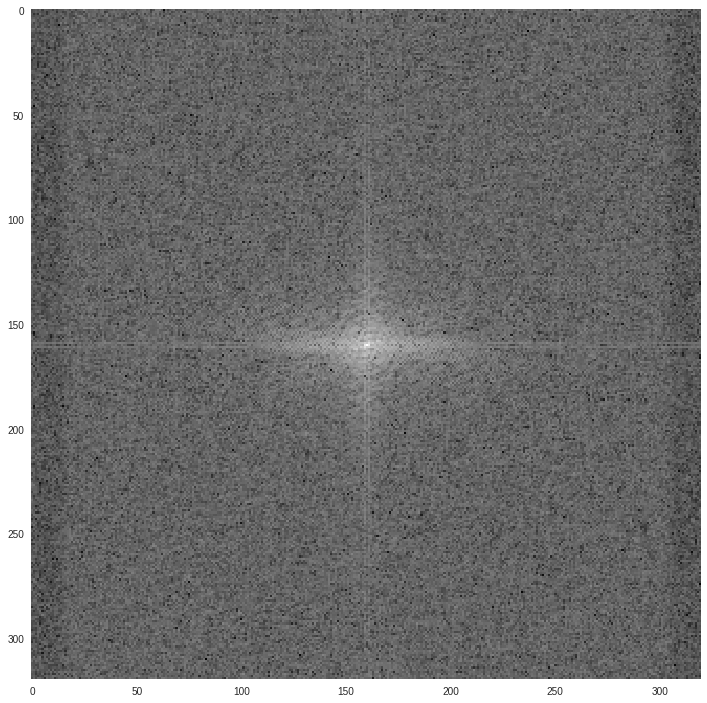

In [58]:
utils.plot.imshowfft(utils.signal_processing.fft2d(cropped_tiled_recon.numpy().squeeze()))

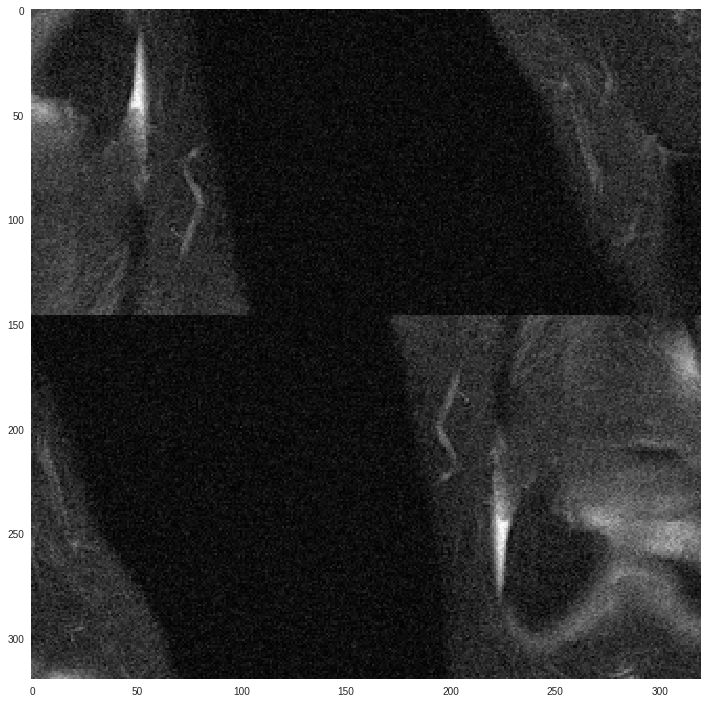

In [59]:
utils.plot.imshowgray(np.abs(utils.signal_processing.ifft2d(utils.signal_processing.fft2d(cropped_tiled_recon.numpy().squeeze()))))

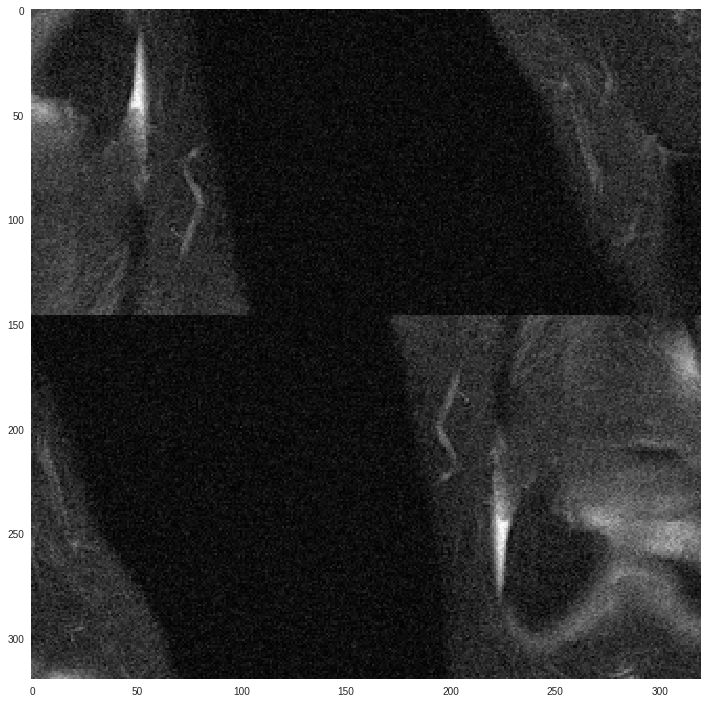

In [60]:
utils.plot.imshowgray(cropped_tiled_recon.numpy().squeeze())

In [61]:
np.allclose(cropped_tiled_recon, np.abs(utils.signal_processing.ifft2d(utils.signal_processing.fft2d(cropped_tiled_recon.numpy().squeeze()))), atol=1e-3)

True

In [62]:
# Great, shows recon from full kspace then crop same as crop of target recon then fft.

# Start from h5_file[reconstruction_esc]

cropped_recon = center_crop(reconstruction_esc[10], (320, 320)).squeeze()
resized_recon = tf.image.resize(np.expand_dims(cropped_recon, -1),
                                                     size=(256, 256),
                                                     method='lanczos3',
                                                     preserve_aspect_ratio=True,
                                                     antialias=True).numpy().squeeze()
kspace_from_cropped_recon = utils.signal_processing.fft2d(cropped_recon)
image_from_cropped_recon_kspace = np.abs(utils.signal_processing.ifft2d(kspace_from_cropped_recon)).squeeze()
resized_image_from_cropped_recon_kspace = tf.image.resize(np.expand_dims(image_from_cropped_recon_kspace, -1),
                                                     size=(256, 256),
                                                     method='lanczos3',
                                                     preserve_aspect_ratio=True,
                                                     antialias=True).numpy().squeeze()

np.allclose(resized_recon, resized_image_from_cropped_recon_kspace)

True

In [63]:
# Start from h5_file[kspace]

image_from_kspace = np.abs(utils.signal_processing.ifft2d(kspace[10]))
cropped_image_from_kspace = center_crop(image_from_kspace, (320, 320))
resized_image_from_kspace = tf.image.resize(np.expand_dims(cropped_image_from_kspace, -1),
                                                     size=(256, 256),
                                                     method='lanczos3',
                                                     preserve_aspect_ratio=True,
                                                     antialias=True).numpy().squeeze()


np.allclose(resized_image_from_kspace, resized_recon)

True

In [64]:
np.random.seed(0)
x = np.random.randn(10, 10)
y = utils.signal_processing.fft2d(x)
x_reconstructed = utils.signal_processing.ifft2d(y)
utils.signal_processing.mean_square_error(x, x_reconstructed.real)

6.558850722107951e-32

In [65]:
np.random.seed(0)
x = 1 * np.random.randn(10, 10) + 3

y = utils.signal_processing.fft2d(x)
tfy = utils.signal_processing.tf_fft2d(x)#.numpy()

x_reconstructed = utils.signal_processing.ifft2d(y)
tfx_reconstructed = utils.signal_processing.tf_ifft2d(tfy)#.numpy()

(np.allclose(tfy, y, atol=1e-5),
 np.allclose(tfx_reconstructed, x_reconstructed, atol=1e-5),
 np.allclose(x, x_reconstructed),
 np.allclose(x, tfx_reconstructed, atol=1e-5)
) # (True, True, True, True)

(True, True, True, True)

In [66]:
utils.signal_processing.mean_square_error(np.abs(x), np.abs(tfx_reconstructed))

1.8196331813027065e-11

In [67]:
utils.signal_processing.mean_square_error(np.abs(x), np.abs(x_reconstructed))

9.649063095775602e-31

In [68]:
utils.signal_processing.mean_square_error(np.abs(tfx_reconstructed), np.abs(x_reconstructed))

1.819633181897414e-11

In [69]:
utils.signal_processing.mean_square_error(np.abs(tfy), np.abs(y))

6.2239618722709946e-12

In [70]:
np.linalg.norm(x_reconstructed), np.linalg.norm(tfx_reconstructed), np.linalg.norm(y), np.linalg.norm(tfy)

(32.215294055997724, 32.215256, 32.21529405599772, 32.21527)

In [71]:

(tf.image.psnr(tf.expand_dims(tf.math.real(tfx_reconstructed), -1), np.expand_dims(np.abs(x), -1), max_val=x.max()),
 tf.image.psnr(tf.expand_dims(tf.math.abs(tfy), -1), np.expand_dims(np.abs(y), -1), max_val=y.max())
)

(<tf.Tensor: id=218, shape=(), dtype=float32, numpy=121.81046>,
 <tf.Tensor: id=256, shape=(), dtype=float32, numpy=141.92375>)

In [75]:
utils.fastmri.read_h5_file('/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5', coils='single')['images'].mean()

2.4288976e-05

In [76]:
ls $dataset_directory/f*

/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5
/home/ubuntu/cs230/data/fastmri/raw/file1000001.h5
/home/ubuntu/cs230/data/fastmri/raw/file1000002.h5
/home/ubuntu/cs230/data/fastmri/raw/file1000003.h5
/home/ubuntu/cs230/data/fastmri/raw/file1000004.h5
/home/ubuntu/cs230/data/fastmri/raw/file1000005.h5


In [77]:
# def load_dataset():#data_locations, batch_size, buffer_size, include_all_parsed_features):
# '''
# Returns iterator of automap data located in `data_locations`.

# data_locations:  A string, a list of strings, or a `tf.Tensor` of string type
# (scalar or vector), representing the filename glob (i.e. shell wildcard)
# pattern(s) that will be matched.
# '''
data_locations = os.path.join(dataset_directory, '*.h5')
dataset = tf.data.Dataset.list_files(data_locations, shuffle=True)
# dataset = tf.data.TFRecordDataset(dataset)

# return dataset

In [78]:
next(iter(dataset))

<tf.Tensor: id=308, shape=(), dtype=string, numpy=b'/home/ubuntu/cs230/data/fastmri/raw/file1000001.h5'>

In [110]:
def tf_example_for_slice_in_mri_volume(index, path, fft, image):
    
    assert len(fft.shape) > 2 and fft.shape[-1] == 2, 'FFT must have 2 channels representing real and imaginary values.'
    
    # Create list of bytes with .tostring() for multidimensional ndarrays.
    example = tf.train.Example(features=tf.train.Features(feature={
        'path': bytes_feature(path),
        'sequence_index': int64_feature(index),
        'fft': bytes_feature(fft.tostring()),
        'image': bytes_feature(image.tostring()),
        
        # save dimension of fft and image to restore these keys
        'image_dimension_0': int64_feature(image.shape[0]),
        'image_dimension_1': int64_feature(image.shape[1]),
        'fft_dimension_0': int64_feature(fft.shape[0]),
        'fft_dimension_1': int64_feature(fft.shape[1])
    }))
    
    return example

In [111]:
def tf_examples_for_h5_file(path):
    
    h5_data = utils.fastmri.read_h5_file(path, coils='single')
    
    # Raw kspace data
    kspace_sequence = h5_data['kspace']
    real_sequence = kspace_sequence.real
    imaginary_sequence = kspace_sequence.imag
    
    fft_sequence = np.concatenate((np.expand_dims(real_sequence, axis=3),
                                   np.expand_dims(imaginary_sequence, axis=3)),
                                  axis=3)
    
    # Expected reconstruction images
    image_sequence = h5_data['images']
    image_sequence = np.expand_dims(image_sequence, axis=-1) # model expects 4 dims

    examples = []
    for i in range(len(image_sequence)):
        example = tf_example_for_slice_in_mri_volume(i, path, fft_sequence[i], image_sequence[i])
        examples.append(example)
    
    return examples

In [112]:
def convert_fastmri_dataset_to_tfrecord_files(raw_data_directory, tfrecord_directory):
    tfrecord_file_pattern = os.path.join(tfrecord_directory, 'shard-{}.tfrecord')
    tfrecord_index = 0
    max_examples_per_tfrecord_file = 8#!!!512
    examples_in_current_tfrecord_file = 0

    os.makedirs(os.path.dirname(tfrecord_file_pattern), exist_ok=True)
    
    tfrecord_path = tfrecord_file_pattern.format(tfrecord_index)
    writer = tf.io.TFRecordWriter(tfrecord_path)
    
    h5_path_pattern = os.path.join(raw_data_directory, '*.h5')
    h5_paths = tf.data.Dataset.list_files(h5_path_pattern, shuffle=True)
    
    for path in h5_paths:
        path = path.numpy()
        try:
            examples = tf_examples_for_h5_file(path)
            for example in examples:
                writer.write(example.SerializeToString())
                examples_in_current_tfrecord_file += 1
                
                if examples_in_current_tfrecord_file >= max_examples_per_tfrecord_file:
                    writer.close()
                    tfrecord_index += 1
                    tfrecord_path = tfrecord_file_pattern.format(tfrecord_index)
                    writer = tf.io.TFRecordWriter(tfrecord_path)
                    examples_in_current_tfrecord_file = 0
                
        except Exception as e:
            print('Error creating example: {}'.format(e))

In [177]:
utils.fastmri.convert_fastmri_dataset_to_tfrecord_files('/home/ubuntu/cs230/data/fastmri/raw', 'delme-fastmri')

In [178]:
ll -h delme-fastmri/

total 460M
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-0.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-10.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-11.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-12.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-13.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-14.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-15.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-16.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-17.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-18.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-19.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-1.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-20.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-21.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-22.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-23.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 shard-24.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  2 21:47 s

In [115]:
for z in tf.data.Dataset.list_files('/home/ubuntu/cs230/data/fastmri/raw/*.h5'):
    break

In [116]:
utils.fastmri.read_h5_file(z.numpy(), 'single')['images'].std()

1.9242041e-05

In [117]:
x=tf_examples_for_h5_file(z.numpy())

In [118]:
e=x[0]

In [164]:
def load_dataset(data_locations, batch_size, shuffle_buffer_size, include_all_parsed_features):
    '''
    Returns iterator of fastMRI data located in `data_locations`.
    
    data_locations:  A string, a list of strings, or a `tf.Tensor` of string type
    (scalar or vector), representing the filename glob (i.e. shell wildcard)
    pattern(s) that will be matched.
    '''
    shuffle_buffer_size = int(shuffle_buffer_size)
    shuffle = shuffle_buffer_size > 0
    print('Loading dataset... Shuffle items? {}. Shuffle buffer: {}'.format(shuffle, shuffle_buffer_size))
    h5_paths = tf.data.Dataset.list_files(data_locations, shuffle=shuffle)
    
    filenames = tf.data.TFRecordDataset.list_files(data_locations)
    dataset = tf.data.TFRecordDataset(filenames)

    # Use `tf.parse_single_example()` to extract data from a `tf.Example`
    # protocol buffer, and perform any additional per-example processing.
    def parser(record):
        keys_to_features = {
            "path": tf.io.FixedLenFeature((), tf.string, ""),
            "sequence_index": tf.io.FixedLenFeature((), tf.int64, -1),
            "fft": tf.io.FixedLenFeature((), tf.string, ''),
            "fft_dimension_0": tf.io.FixedLenFeature((), tf.int64, -1),
            "fft_dimension_1": tf.io.FixedLenFeature((), tf.int64, -1),
            "image": tf.io.FixedLenFeature((), tf.string, ''),
            "image_dimension_0": tf.io.FixedLenFeature((), tf.int64, -1),
            "image_dimension_1": tf.io.FixedLenFeature((), tf.int64, -1),
        }
        parsed = tf.io.parse_single_example(record, keys_to_features)
        
        # Perform additional preprocessing on the parsed data.
        parsed['fft'] = tf.io.decode_raw(parsed['fft'], out_type=tf.float32)
        parsed['image'] = tf.io.decode_raw(parsed['image'], out_type=tf.float32)
        
        parsed['fft'] = tf.reshape(parsed['fft'], [parsed['fft_dimension_0'], parsed['fft_dimension_1'], 2])
        parsed['image'] = tf.reshape(parsed['image'], [parsed['image_dimension_0'], parsed['image_dimension_1'], 1])
        
        if include_all_parsed_features:
            return parsed
        
        # We only want input and expected output during training stage (X, Y)
        return parsed['fft'], parsed['image']
    
    # Use `Dataset.map()` to build a pair of a feature dictionary and a label
    # tensor for each example.
    dataset = dataset.map(parser)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=int(shuffle_buffer_size))
    dataset = dataset.batch(batch_size)

    # Each element of `dataset` is tuple of (input, output) pairs or a dictionary of features
    # (in which each value is a batch of values for that feature), and a batch of labels.
    return dataset

In [181]:
batch = next(iter(utils.fastmri.load_dataset('delme-fastmri/*.tfrecord', 7, 1.4, True)))

Loading dataset... Shuffle items? True. Shuffle buffer: 1


In [182]:
tf.complex(batch['fft'][..., 0], batch['fft'][..., 1]).numpy().min()

(-0.00042694286-0.00027403733j)